In [8]:


# =============================================================================
# ========================      EXPLANATION       =============================
# This script trains an MLP model on the Stanford Dogs dataset using a selected
# hyperparameter configuration from a predefined grid search space.
#
# - The model is trained according to the configuration defined by SELECTED_ID.
# - To train your own configuration, simply change the value of SELECTED_ID.
# - The model will automatically train using the corresponding hyperparameters.
# - The best validation accuracy and its epoch will be computed after training.
# - All training results are automatically saved to:
#       results/results.csv
# - The list of all available configurations is saved to:
#       results/config_list.csv
#
# Each team member should update SELECTED_ID with their assigned configuration ID,
# run the code, and share the generated results.csv file for aggregation.
# =============================================================================




# ==========================================
# GEREKLİ PAKETLERİN OTOMATİK KURULUMU
# AUTOMATIC INSTALLATION OF NECESSARY PACKAGES
# ==========================================

import subprocess
import sys

required_packages = [
    "tensorflow",
    "numpy",
    "matplotlib",
    "scipy"
]

def install_if_missing(package):
    try:
        __import__(package)
        print(f"'{package}' zaten yüklü.")
    except ImportError:
        print(f"'{package}' bulunamadı. Kuruluyor...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg in required_packages:
    install_if_missing(pkg)

print("\nTüm gerekli paketler yüklendi.\n")


'tensorflow' zaten yüklü.
'numpy' zaten yüklü.
'matplotlib' zaten yüklü.
'scipy' zaten yüklü.

Tüm gerekli paketler yüklendi.



In [9]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
import csv
import tarfile
import urllib.request
import shutil
from scipy.io import loadmat

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# ==========================================
# BASE CONFIG (her config için ortak olan kısım)
# ==========================================
BASE_CONFIG = {
    # Paths
    "BASE_DIR": "/content/datasets/stanford_dogs",
    "SPLIT_FOLDER": "stanford_dogs_split",   # içinde train/ ve test/ var

    # Data
    "IMG_SIZE": 64,      # şimdilik sabit
    "VAL_SPLIT": 0.1,    # train'in %10'u validation

    # Training genel
    "EPOCHS": 20,
    "EARLY_STOP": True,
    "EARLY_STOP_PATIENCE": 5,

    # Reproducibility
    "SEED": 42,
}

# BASE_DIR oluştur
os.makedirs(BASE_CONFIG["BASE_DIR"], exist_ok=True)

# ==========================================
# DATASET DOWNLOAD & PREPARATION (IF NEEDED)
# ==========================================
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
LISTS_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

def download_if_not_exists(url, dest_path):
    if os.path.exists(dest_path):
        print(f"[INFO] File already exists, skipping download: {dest_path}")
        return
    print(f"[INFO] Downloading from {url} → {dest_path}")
    urllib.request.urlretrieve(url, dest_path)
    print("[INFO] Download finished.")

def extract_if_not_exists(tar_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
    print(f"[INFO] Extracting {tar_path} → {extract_to}")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("[INFO] Extract finished.")

def create_train_test_split(base_dir, split_folder="stanford_dogs_split"):
    """
    base_dir:
        /content/datasets/stanford_dogs
            Images/
            train_list.mat
            test_list.mat
            file_list.mat
    """
    split_dir = os.path.join(base_dir, split_folder)
    if os.path.exists(split_dir):
        print(f"[INFO] Split folder already exists: {split_dir}")
        return split_dir

    images_dir = os.path.join(base_dir, "Images")
    lists_dir = base_dir  # .mat dosyaları doğrudan base_dir içinde

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images folder not found at {images_dir}")

    train_mat_path = os.path.join(lists_dir, "train_list.mat")
    test_mat_path = os.path.join(lists_dir, "test_list.mat")

    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        raise FileNotFoundError(
            f"train_list.mat veya test_list.mat bulunamadı. Aranan klasör: {lists_dir}"
        )

    print("[INFO] Creating train/test split folder structure...")
    os.makedirs(split_dir, exist_ok=True)
    train_root = os.path.join(split_dir, "train")
    test_root = os.path.join(split_dir, "test")
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    train_mat = loadmat(train_mat_path)
    test_mat = loadmat(test_mat_path)

    def mat_file_list_to_str_list(file_list_mat):
        # file_list_mat → (N,1) array, her eleman iç içe string
        paths = []
        for i in range(file_list_mat.shape[0]):
            entry = file_list_mat[i][0]
            while isinstance(entry, np.ndarray):
                entry = entry[0]
            paths.append(str(entry))
        return paths

    train_files = mat_file_list_to_str_list(train_mat["file_list"])
    train_labels = train_mat["labels"].reshape(-1)

    test_files = mat_file_list_to_str_list(test_mat["file_list"])
    test_labels = test_mat["labels"].reshape(-1)

    print("[INFO] Copying train images into split folder...")
    for rel_path, label in zip(train_files, train_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir = os.path.join(train_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print("[INFO] Copying test images into split folder...")
    for rel_path, label in zip(test_files, test_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir = os.path.join(test_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print(f"[INFO] Train/test split created at: {split_dir}")
    return split_dir

def prepare_stanford_dogs_dataset(base_dir, split_folder):
    """
    - Creates base_dir if not exists
    - Downloads images.tar and lists.tar if missing
    - Extracts them
    - Creates stanford_dogs_split/train and stanford_dogs_split/test if needed
    """
    os.makedirs(base_dir, exist_ok=True)

    images_tar_path = os.path.join(base_dir, "images.tar")
    lists_tar_path = os.path.join(base_dir, "lists.tar")

    # Download tars if needed
    download_if_not_exists(IMAGES_URL, images_tar_path)
    download_if_not_exists(LISTS_URL, lists_tar_path)

    # images.tar → Images/...
    if not os.path.exists(os.path.join(base_dir, "Images")):
        extract_if_not_exists(images_tar_path, base_dir)
    else:
        print("[INFO] Images folder already exists, skipping extract.")

    # lists.tar → train_list.mat, test_list.mat, file_list.mat base_dir içine
    train_mat_path = os.path.join(base_dir, "train_list.mat")
    test_mat_path = os.path.join(base_dir, "test_list.mat")

    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        extract_if_not_exists(lists_tar_path, base_dir)
    else:
        print("[INFO] .mat list files already exist, skipping extract.")

    # Create split if needed
    create_train_test_split(base_dir, split_folder)

# Dataset hazırlanması:
prepare_stanford_dogs_dataset(
    BASE_CONFIG["BASE_DIR"],
    BASE_CONFIG["SPLIT_FOLDER"]
)

# ==========================================
# GRID SEARCH SPACE (~72 config)
# ==========================================
GRID_SPACE = {
    # 3 farklı mimari
    "HIDDEN_LAYERS": [
        [256],            # küçük ve hızlı model
        [512, 256],       # orta derinlikte model
        [512, 256, 128],  # derin model
    ],

    # 3 farklı learning rate
    "LEARNING_RATE": [1e-2, 1e-3, 1e-4],

    # 2 farklı batch size
    "BATCH_SIZE": [32, 64],

    # 2 farklı dropout
    "DROPOUT": [0.3, 0.5],

    # 2 farklı L2
    "L2": [1e-3, 1e-4],
}

# ==========================================
# CONFIGS OLUŞTUR – TÜM KOMBINASYONLAR
# ==========================================
CONFIGS = []
i = 1

for layers_cfg, lr, bs, dropout, l2 in itertools.product(
    GRID_SPACE["HIDDEN_LAYERS"],
    GRID_SPACE["LEARNING_RATE"],
    GRID_SPACE["BATCH_SIZE"],
    GRID_SPACE["DROPOUT"],
    GRID_SPACE["L2"],
):
    cfg = BASE_CONFIG.copy()
    cfg.update({
        "ID": f"C{i:03d}",           # C001, C002, ... C072
        "HIDDEN_LAYERS": layers_cfg,
        "LEARNING_RATE": lr,
        "BATCH_SIZE": bs,
        "DROPOUT": dropout,
        "L2": l2,
    })
    CONFIGS.append(cfg)
    i += 1

print("Toplam config sayısı:", len(CONFIGS))  # 72 bekliyoruz

# ==========================================
# TÜM CONFIG'LERİ TEK DOSYAYA KAYDET
# ==========================================
os.makedirs("results", exist_ok=True)
config_list_path = "results/config_list.csv"

with open(config_list_path, "w", newline="") as f:
    writer = csv.writer(f)
    # Başlık satırı
    writer.writerow([
        "config_id",
        "hidden_layers",
        "learning_rate",
        "batch_size",
        "dropout",
        "l2"
    ])
    # Tüm config'leri yaz
    for cfg in CONFIGS:
        writer.writerow([
            cfg["ID"],
            str(cfg["HIDDEN_LAYERS"]),
            cfg["LEARNING_RATE"],
            cfg["BATCH_SIZE"],
            cfg["DROPOUT"],
            cfg["L2"],
        ])

print("Tüm config'ler kaydedildi →", config_list_path)


TensorFlow version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO] File already exists, skipping download: /content/datasets/stanford_dogs/images.tar
[INFO] File already exists, skipping download: /content/datasets/stanford_dogs/lists.tar
[INFO] Images folder already exists, skipping extract.
[INFO] .mat list files already exist, skipping extract.
[INFO] Split folder already exists: /content/datasets/stanford_dogs/stanford_dogs_split
Toplam config sayısı: 72
Tüm config'ler kaydedildi → results/config_list.csv


In [10]:
# ==========================================
# HANGİ CONFIG'İ KULLANACAĞIZ?
# Grup içinde paylaşım için sadece burayı değiştirmeniz yeterli.

# WHICH CONFIG WILL WE USE?
# To share within the group, simply change this.
# ==========================================

SELECTED_ID = "C001"   # !!!!!!Choose the (config) ID you want to train!!!! (from C001 to C072 ) !!!!!!!!!!

CONFIG = next(c for c in CONFIGS if c["ID"] == SELECTED_ID)

print("Seçilen config ID:", CONFIG["ID"])
print("HIDDEN_LAYERS :", CONFIG["HIDDEN_LAYERS"])
print("LEARNING_RATE :", CONFIG["LEARNING_RATE"])
print("BATCH_SIZE    :", CONFIG["BATCH_SIZE"])
print("DROPOUT       :", CONFIG["DROPOUT"])
print("L2            :", CONFIG["L2"])

# ==========================================
# Seed ayarı (CONFIG'ten)
# Seed setting (from CONFIG)
# ==========================================

SEED = CONFIG["SEED"]

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("Global SEED set to:", SEED)


Seçilen config ID: C001
HIDDEN_LAYERS : [256]
LEARNING_RATE : 0.01
BATCH_SIZE    : 32
DROPOUT       : 0.3
L2            : 0.001
Global SEED set to: 42


In [11]:
# ==========================================
# Dataset yükleme (stanford_dogs_split/train & test)
# Loading dataset (stanford_dogs_split/train & test)
# ==========================================

BASE_DIR  = CONFIG["BASE_DIR"]
SPLIT_DIR = os.path.join(BASE_DIR, CONFIG["SPLIT_FOLDER"])

train_dir = os.path.join(SPLIT_DIR, "train")
test_dir  = os.path.join(SPLIT_DIR, "test")

IMG_SIZE   = CONFIG["IMG_SIZE"]
BATCH_SIZE = CONFIG["BATCH_SIZE"]

print("Train dir:", train_dir)
print("Test dir :", test_dir)

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED,   # deterministik shuffle
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıf sayısı:", num_classes)
print("İlk sınıflar:", class_names[:10])


def ds_to_numpy(dataset):
    images = []
    labels = []
    for x, y in dataset:
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)


x_train, y_train = ds_to_numpy(train_ds)
x_test, y_test   = ds_to_numpy(test_ds)

print("x_train shape (önce):", x_train.shape)

# Normalize + flatten
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = x_train.reshape(len(x_train), -1)
x_test  = x_test.reshape(len(x_test), -1)

input_dim = x_train.shape[1]
print("x_train shape (flatten sonrası):", x_train.shape)
print("Input dim:", input_dim)


Train dir: /content/datasets/stanford_dogs/stanford_dogs_split/train
Test dir : /content/datasets/stanford_dogs/stanford_dogs_split/test
Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.
Sınıf sayısı: 120
İlk sınıflar: ['class_001', 'class_002', 'class_003', 'class_004', 'class_005', 'class_006', 'class_007', 'class_008', 'class_009', 'class_010']
x_train shape (önce): (12000, 64, 64, 3)
x_train shape (flatten sonrası): (12000, 12288)
Input dim: 12288


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,145,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,177,592 (12.12 MB)

 Trainable params: 3,177,080 (12.12 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.0191 - loss: 7.7294 - val_accuracy: 0.0133 - val_loss: 6.7412
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.0243 - loss: 5.2398 - val_accuracy: 0.0100 - val_loss: 6.0899
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.0197 - loss: 5.1399 - val_accuracy: 0.0192 - val_loss: 5.7075
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.0229 - loss: 5.0300 - val_accuracy: 0.0158 - val_loss: 5.4013
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.0226 - loss: 4.9419 - val_accuracy: 0.0125 - val_loss: 5.4697
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.0246 - loss: 4.8758 - val_accuracy: 0.0117 - val_loss: 5.1599
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.0240 - loss: 4.8288 - val_accuracy: 0.0117 - val_loss: 5.9066
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.0251 - loss: 4.8556 - 

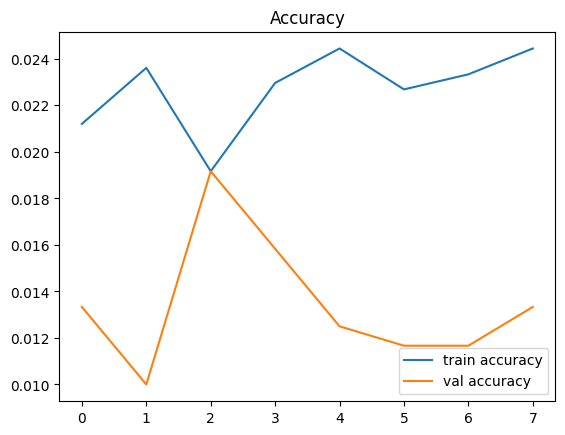

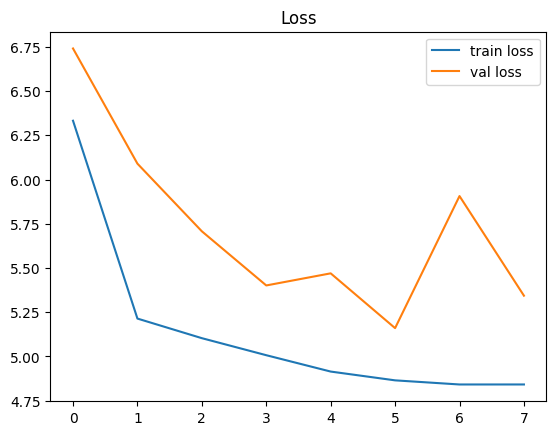

In [12]:
# ==========================================
# MLP model (CONFIG'e göre) (by CONFIG)
# ==========================================

def build_mlp(input_dim, num_classes, config):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for units in config["HIDDEN_LAYERS"]:
        x = layers.Dense(
            units,
            activation=None,
            kernel_regularizer=keras.regularizers.l2(config["L2"]),
            use_bias=False,
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(config["DROPOUT"])(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_mlp(input_dim, num_classes, CONFIG)
model.summary()

# ==========================================
# Compile
# ==========================================

opt = keras.optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"])


model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = []
if CONFIG["EARLY_STOP"]:
    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",               # val_loss yerine val_accuracy
        patience=CONFIG["EARLY_STOP_PATIENCE"],
        mode="max",                           # en büyük val_accuracy'yi arıyoruz
        restore_best_weights=True,
    )


    callbacks.append(early_stop)

# ==========================================
# Training
# ==========================================

history = model.fit(
    x_train,
    y_train,
    batch_size=CONFIG["BATCH_SIZE"],
    epochs=CONFIG["EPOCHS"],
    validation_split=CONFIG["VAL_SPLIT"],
    callbacks=callbacks,
)


# ==========================================
# En iyi validation accuracy'ye göre epoch'u seç
# Select the epoch with best validation accuracy
# ==========================================

val_acc_history = history.history["val_accuracy"]
train_acc_history = history.history["accuracy"]

# En yüksek validation accuracy
best_val_acc = max(val_acc_history)

# Bu değerin hangi epoch'ta olduğunu bul (0-based index)
best_epoch_index = val_acc_history.index(best_val_acc)

# İnsan okunabilir epoch numarası (1-based)
best_epoch = best_epoch_index + 1

# Aynı epoch'taki train accuracy
best_train_acc = train_acc_history[best_epoch_index]

print(f"\nBest epoch (val_accuracy'ye göre): {best_epoch}")
print(f"Best val_accuracy: {best_val_acc:.4f}")
print(f"Train accuracy at best epoch: {best_train_acc:.4f}")

# ==========================================
# Test değerlendirme
# Test evaluation
# ==========================================

# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f"Test loss: {test_loss:.4f}")
# print(f"Test accuracy: {test_acc:.4f}")

# ==========================================
# Accuracy değerini results'a kaydet
# Save the accuracy value to results
# ==========================================

import csv
from datetime import datetime

os.makedirs("results", exist_ok=True)
csv_path = "results/results.csv"

write_header = not os.path.exists(csv_path)

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)

    if write_header:
        writer.writerow([
            "timestamp",
            "config_id",
            "best_epoch",
            "best_val_accuracy",
            "train_accuracy_at_best_epoch",
        ])

    writer.writerow([
        datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        CONFIG["ID"],
        best_epoch,
        float(best_val_acc),
        float(best_train_acc),
    ])

print(f"\nSonuç kaydedildi → {csv_path}")

# ==========================================
# Örnek tahmin
# ==========================================

predictions = model.predict(x_test[:5])
pred_labels = predictions.argmax(axis=1)

print("Gerçek label'lar:", y_test[:5])
print("Tahmin label'lar:", pred_labels)

print("\nGerçek sınıf isimleri:")
for i in range(5):
    print(i, "->", class_names[y_test[i]])

print("\nTahmin sınıf isimleri:")
for i in range(5):
    print(i, "->", class_names[pred_labels[i]])


# ==========================================
# Eğitim grafikleri
# Training graphics
# ==========================================

plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()
